# Brute force optimizer
The end result will be a dataframe with columns: #total trades, #wins, #losses, mean win %, mean loss %, max # of winning trades in a row, max # of losing trades in a row, max drawdown %, max drawdown length, all drawdown lengths (type:list of timedeltas), returns (type:list of floats), and maybe some more

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from IPython.display import clear_output
import time

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [19]:
A = "ARDRUSDT"
B = "LSKUSDT"

In [20]:
df1 = pd.read_csv(f"../data/minute/{A}-minute.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv(f"../data/minute/{B}-minute.csv", index_col=0, parse_dates=True)

In [21]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
df = df[1000:]
df = df.dropna()

## Hedge Ratio calculation

In [25]:
start = time.time()
ds = 20000 #downsample
hedge_ratio = np.full(df.shape[0], np.nan)
l = math.floor(len(hedge_ratio)/ds)
index = []
for t in np.arange(l):
    clear_output()
    print(f"{t} < {l}")
    regress_results = sm.ols(formula="B ~ A",
                             data=df[:t*ds+1]).fit()  # Note this can deal with NaN in top row
    hedge_ratio[t] = regress_results.params[1]
    index.append(df.index[t*ds+1])
time.time()-start

30 < 31


3.197784185409546

## Functions

In [26]:
def get_spread(lookback, length=700_000):
    """returns the spread. Lookback is for mean and std. length is [-length:] of spread"""
    hr = pd.Series(hedge_ratio).dropna().rename("hr").to_frame()

    hr["index"] = index
    hr.set_index("index", inplace=True)

    spread = pd.DataFrame(hr.hr, index=df.index)

    spread.ffill(inplace=True)

    spread = pd.Series((df['B'] - spread["hr"] * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] =  spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])

    spread = spread.dropna()

    spread["A"] = df1["close"].reindex(spread.index)
    spread["Ah"] = df1["high"].reindex(spread.index)
    spread["Al"] = df1["low"].reindex(spread.index)

    spread["B"] = df2["close"].reindex(spread.index)
    spread["Bh"] = df2["high"].reindex(spread.index)
    spread["Bl"] = df2["low"].reindex(spread.index)
    return spread[-length:]

def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

def run_backtest(spread, thres, sell_thres, fee=0.002, interest=0.002):
    total, p_total = 0, 0 #Previous total
    cusum, returns = [], []
    price_a, price_b, long = None, None, None #Values: None, "A", "B"
    long_a, long_b, liquidate,  dd_indices= [], [], [], [] #Drawdown indicies
    dd_i = True
    for i in range(spread.shape[0]):
        z = spread.zscore[i]
        if long == None: # Looking to buy
            if z>thres or z<-thres:
                al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
                price_a = ah if z > thres else al
                price_b = bl if z > thres else bh
                long = "A" if z > thres else "B"
                long_a.append(spread.index[i]) if z > thres else long_b.append(spread.index[i])
        if (long == "A" and z<-sell_thres) or (long == "B" and z>sell_thres): #Liquidate positions
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            gain = 0
            if long=="A":
                gain = liquidate_assets(price_b, bh, al, price_a, fee, long_a[-1], spread.index[i], interest)
            else:
                gain = liquidate_assets(price_a, ah, bl, price_b, fee, long_b[-1], spread.index[i], interest)
            returns.append(gain)
            total += gain
            price_a, price_b, long = None, None, None
            liquidate.append(spread.index[i])
        cusum.append(total)

        if total < p_total:
            if dd_i:
                dd_indices.append(spread.index[i])
                dd_i = False
        else:
            if not dd_i:
                dd_indices.append(spread.index[i])
                dd_i = True
            p_total = total
    if total < p_total:
        dd_indices.append(spread.index[i])
    drawdowns = get_drawdowns(dd_indices)
    return long_a, long_b, liquidate, cusum, returns, drawdowns
        
def liquidate_assets(x1, x2, y1, y2, fee, d1, d2, interest):
    interest = ((d2-d1).days + 1) * interest
    total = (x1 - x2)/x1 - 2*fee - interest
    total += (y1 - y2)/y1 - 2*fee - interest
    return total

def get_drawdowns(dd_indices, sort=False):
    a = dd_indices[1::2]
    b = dd_indices[::2]
    a = np.array(a)
    b = np.array(b[:len(a)])
    c = a-b
    if sort:
        c.sort()
        c = c[::-1]
    return c

def convert_timedelta_to_seconds(td):
    """converts timedelta to seconds"""
    return td.days*24*60*60 + td.seconds

<AxesSubplot:>

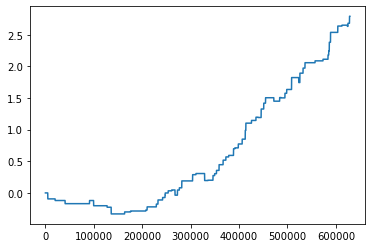

In [27]:
spread = get_spread(4250) #ds=10000
long_a, long_b, liquidate, cusum, returns, drawdowns = run_backtest(spread, 4.8, 0)
pd.Series(cusum).plot()

<AxesSubplot:>

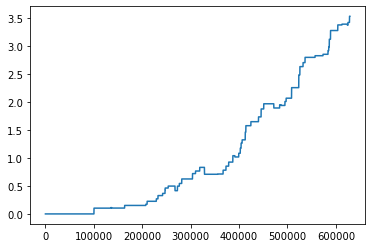

In [12]:
spread = get_spread(4250) #ds=1000
long_a, long_b, liquidate, cusum, returns, drawdowns = run_backtest(spread, 4.8, 0)
pd.Series(cusum).plot()

<AxesSubplot:>

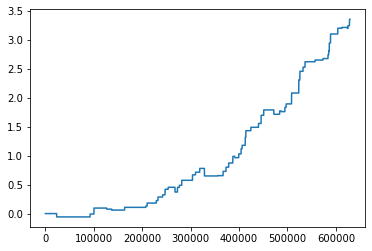

In [18]:
spread = get_spread(4250) #ds=100
long_a, long_b, liquidate, cusum, returns, drawdowns = run_backtest(spread, 4.8, 0)
pd.Series(cusum).plot()

## For loop

In [8]:
for lookback in [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000, 10000]:
    
    d = {"lookback":[], "thres":[], "sell_thres":[], "cusum":[], "returns":[], "drawdowns":[]}
    spread = get_spread(lookback)
    
    for thres in [0.5, 0.75, 1., 1.25, 1.5, 1.75, 2., 2.5, 3., 4.]:
        
        for sell_thres in [-2., -1.5, -1., -0.5, -0.25, 0., 0.25, 0.5, 0.75, 1., 1.25, 1.5, 2., 2.5, 3.]:
            if sell_thres <= -thres:
                continue
            print(f"Now doing lookback: {lookback}, thres: {thres}, sell_thres: {sell_thres}, safe to kill kernel")
            print(f"Length: {len(spread)} should == 700_000")
            long_a, long_b, liquidate, cusum, returns, drawdowns = run_backtest(spread, thres, sell_thres)
            
            print(f"DON'T KILL KERNEL, ADDING TRADES")
            time.sleep(1)
            d["lookback"].append(lookback)
            d["thres"].append(thres)
            d["sell_thres"].append(sell_thres)
            d["cusum"].append(cusum)
            d["returns"].append(list(map(lambda x: round(x, 5), returns)))
            d["drawdowns"].append(list(map(lambda x: convert_timedelta_to_seconds(x), drawdowns)))
            
            clear_output()
        
    result_so_far = pd.DataFrame(d)
    result_so_far.to_csv(f"../data/generated/{A}-{B}-{str(lookback)}.csv", index=False)

Now doing lookback: 10000, thres: 1.0, sell_thres: 0.0, safe to kill kernel
Length: 622954 should == 700_000


KeyboardInterrupt: 

In [9]:
for lookback in [4500, 4750, 5000, 5250, 5500]:
    
    d = {"lookback":[], "thres":[], "sell_thres":[], "cusum":[], "returns":[], "drawdowns":[]}
    spread = get_spread(lookback)
    
    for thres in [3.2, 3.4, 3.6, 3.8, 4., 4.2, 4.4, 4.6, 4.8]:
        
        for sell_thres in [-0.25, -0.1, 0, 0.1, 0.25]:
            if sell_thres <= -thres:
                continue
            print(f"Now doing lookback: {lookback}, thres: {thres}, sell_thres: {sell_thres}, safe to kill kernel")
            print(f"Length: {len(spread)} should == 700_000")
            long_a, long_b, liquidate, cusum, returns, drawdowns = run_backtest(spread, thres, sell_thres)
            
            print(f"DON'T KILL KERNEL, ADDING TRADES")
            time.sleep(1)
            d["lookback"].append(lookback)
            d["thres"].append(thres)
            d["sell_thres"].append(sell_thres)
            d["cusum"].append(cusum)
            d["returns"].append(list(map(lambda x: round(x, 5), returns)))
            d["drawdowns"].append(list(map(lambda x: convert_timedelta_to_seconds(x), drawdowns)))
            
            clear_output()
        
    result_so_far = pd.DataFrame(d)
    result_so_far.to_csv(f"../data/generated/{A}-{B}-{str(lookback)}.csv", index=False)